In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import time
import os
import random

from pathlib import Path

from datetime import datetime, date, timedelta

import xarray as xr

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as D

from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import mean_squared_error, r2_score

from layers import *

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import captum
import captum.robust

from captum.attr import LayerConductance, LayerActivation, LayerIntegratedGradients
from captum.attr import IntegratedGradients, DeepLift, GradientShap, NoiseTunnel, FeatureAblation

from captum.attr import visualization as viz

In [3]:
BATCH_SIZE = 128
N_SPLITS = 5
SEED = 42

TIMELAG = 92
H_DIM = 64
WIDTH = 92

FONT_SIZE = 12

STAGE = 'development'

USE_GROUP = True

MODEL_PATH = "../development/models/2022-02-12_00-28"

print(f"Model save path: {MODEL_PATH}")

Model save path: ../development/models/2022-02-12_00-28


In [4]:
cells = gpd.read_file("../development/grid_cells.geojson")

In [5]:
# Numpy print option
np.set_printoptions(precision=4, suppress=True, threshold=1000);
# Seaborn figuresize
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style("whitegrid")

In [6]:
### Loading date

In [7]:
start_data = datetime(2014,9,1)

labels_2013_2019 = pd.read_csv("../development/train_labels.csv", index_col=[0])
labels_2020_2021 = pd.read_csv("../development/labels_2020_2021.csv", index_col=[0])

labels_2013_2019.columns = pd.to_datetime(labels_2013_2019.columns)
labels_2020_2021.columns = pd.to_datetime(labels_2020_2021.columns)

targets_df = pd.merge(
    labels_2013_2019, labels_2020_2021, how = "outer", left_index = True, right_index = True)

# Targets:
# Get datas only with features
targets_df = targets_df.loc[:, start_data:]
targets_df = targets_df.astype('f4')

In [8]:
# Get cell_idx, data_idx for known SWE
cell_idx, data_idx = np.nonzero((~np.isnan(targets_df.values)).astype(int))
# Convert to cell_id and times
target_values = targets_df.values[cell_idx, data_idx].astype(np.float32)
cell_idx = targets_df.index[cell_idx]
data_idx = pd.to_datetime(targets_df.columns[data_idx])

# bin targets
binc = np.arange(10, 120, 10)
y = np.digitize(target_values, bins=binc)

In [9]:
ds = xr.open_dataset(f"../{STAGE}/dataset/dataset.nc", engine='netcdf4')
ds.load();
ds.close();

In [10]:
band = xr.concat([
        (ds.t00 - 273.15) / 20,
        (ds.t12 - 273.15) / 20,
        (ds.sdwe**0.25 - 1),
        (ds.pwat - 8) / 7,
        ds.refc / 10,
        ds.u / 20,
        ds.v / 20,
        ds.sdwea,
        ds.NDSI,
        (ds.sd / 200) - 3.6,
    ], dim = 'feature'
)

band_values = band.ffill('time').fillna(0).data

In [11]:
FEATURES = ['t00', 't12', 'sdwe', 'pwat', 'refc', 'u80', 'v80', 'sdwes', 'NDSI', 'sd']

xds = xr.Dataset(
    data_vars = dict(
            band = (["feature", "time", "cell_id"], band_values),
            target = (["cell_id", "days"], targets_df.values),
            dem = (["cell_id", "x", "y"], ds.dem.data / 1000 - 2.25),
            soil = (["cell_id", "x", "y"], ds.soil.data),
    ),
    coords = dict(
            feature = FEATURES,
            cell_id = ds.coords['cell_id'].data,
            days = targets_df.columns,
            time = ds.coords['time'].data,
        ),
)

In [12]:
class SnowDataset(D.Dataset):

    def __init__(self, cells, datas, xds, timelag : int = TIMELAG):
        
        self.xds = xds
        self.datas = datas
        self.cells = cells
        self.tlag = timedelta(days=timelag)
        self.days = timelag
        
    def __len__(self):
        return len(self.cells)

    def __getitem__(self, idx):

        cell_id = self.cells[idx]
        data_idx = self.datas[idx]
          
        features = self.xds.band.loc[
            :, data_idx-self.tlag : data_idx-timedelta(1), cell_id].data
        
        dem_value = self.xds.dem.loc[cell_id].data[None]
        soil_value = self.xds.soil.loc[cell_id].data
        target = self.xds.target.loc[cell_id, data_idx].data
        
        return features, dem_value, soil_value, target[None]

In [13]:
class SnowNet(nn.Module):
    def __init__(self, features=6, h_dim=32,
                 width=48, timelag=21, out_dim=1, embedding_dim = 3):
        
        super(SnowNet, self).__init__()
        self.features = features
        self.timelag = timelag 
        self.modes, self.width = width // 2, width
        self.h_dim, self.in_dim = h_dim, timelag
        self.k = 2
        self.embs = nn.Embedding(num_embeddings = 20,
                                 embedding_dim = embedding_dim)
        self.embs.weight.data[0] *= 0
        
        if self.timelag == self.width:
            self.fc0 = nn.Identity()
        else:
            self.fc0 = nn.Linear(self.timelag, self.width)
        
        self.step0 = nn.Sequential(
            nn.Conv1d(self.features, self.h_dim, 1, bias = False),
            nn.BatchNorm1d(self.h_dim), nn.PReLU(),
            nn.Conv1d(self.h_dim, self.h_dim, 1),
        )
        
        # Conv layers:
        self.conv0dem = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=3, bias=False), #  + embedding_dim
            nn.BatchNorm2d(6), nn.PReLU(),
            nn.Conv2d(in_channels = 6, out_channels = 9, kernel_size = 3, bias = False),
            nn.BatchNorm2d(9), nn.PReLU(),
            nn.Conv2d(in_channels = 9, out_channels = 6, kernel_size = 3, bias = False),
            nn.Flatten(),
            nn.Linear(6*4*4, self.width), 
        )
        
        self.conv1soil = nn.Sequential(
            nn.Conv2d(embedding_dim, 6, kernel_size=3, bias=False), #  + embedding_dim
            nn.BatchNorm2d(6), nn.PReLU(),
            nn.Conv2d(in_channels = 6, out_channels = 9, kernel_size = 3, bias = False),
            nn.BatchNorm2d(9), nn.PReLU(),
            nn.Conv2d(in_channels = 9, out_channels = 6, kernel_size = 3, bias = False),
            nn.Flatten(),
            nn.Linear(6*4*4, self.width), 
        )
        
        self.layers = nn.Sequential(
            SpectralBlock1d(self.h_dim + 2, self.h_dim, int(self.modes*1/2),
                            activator=nn.PReLU), 
            SpectralBlock1d(self.h_dim, self.h_dim, int(self.modes*1/2),
                            activator=nn.PReLU),  
            SpectralBlock1d(self.h_dim, self.h_dim, int(self.modes*1/2),
                            activator=nn.PReLU), 
            SpectralBlock1d(self.h_dim, self.h_dim, int(self.modes*1/4),
                            activator=nn.PReLU),      
        )
            
        self.step_t = nn.Conv1d(self.h_dim, 1, 1)
        self.fc1 = nn.Linear(width, out_dim)
        
    def forward(self, x, dem, soil):
        
        x = self.fc0(x)
        x = self.step0(x)
        
        soil = self.embs(soil.long()).permute(0,3,1,2)
        d0 = self.conv0dem(dem)
        d1 = self.conv1soil(soil)
        x = torch.cat([
            x, d0.view(-1, 1, self.width), d1.view(-1, 1, self.width)], 1)

        x = self.layers(x)

        x = self.step_t(x)
        x = self.fc1(x)
        
        return x.squeeze(-1)
    
class SnowNetPatched(SnowNet):
    def forward(self, x, dem, soil):
        x = self.fc0(x)
        x = self.step0(x)
        d0 = self.conv0dem(dem)
        d1 = self.conv1soil(soil)
        x = torch.cat([
            x, d0.view(-1, 1, self.width), d1.view(-1, 1, self.width)], 1)

        x = self.layers(x)

        x = self.step_t(x)
        x = self.fc1(x)
        
        return x.squeeze(-1)

In [14]:
def get_figure(yt, yp, binc=binc):
    errors = np.abs(yt - yp).squeeze()
    xbin = np.digitize(yt, binc).squeeze()
    figure = sns.boxplot(x=xbin, y=errors)
    figure.set(ylim=(0, 100), xlim=(-1, 12))
    medians = [np.median(errors[xbin == i]) for i in np.unique(xbin)]
    vertical_offset = np.median(errors) * 0.4 # offset from median for display

    for xtick in figure.get_xticks():
        figure.text(xtick, medians[xtick] + vertical_offset, f"{medians[xtick]:.3f}", 
            horizontalalignment='center',size='x-small',color='w',weight='semibold')
        
    rmse_score = mean_squared_error(yt, yp, squared=False)
    figure.annotate(f"RMSE: {rmse_score:.3f}", xytext=(0.1, 0.9),
            xy=(0.1, 0.9), xycoords="axes fraction", fontsize=FONT_SIZE);
    
    return figure

In [15]:
params = {'X': target_values, 'y' : y }

skf = StratifiedGroupKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)
params['groups'] = cell_idx

In [16]:
models = []
predicted = np.empty(cell_idx.shape[0], dtype=np.float32)
folds = np.empty(cell_idx.shape[0], dtype=np.float32)

feature_importances = np.empty((cell_idx.shape[0], 12), dtype=np.float32)

for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(**params)):
    
    model = SnowNet(features=len(FEATURES), h_dim=H_DIM, width=WIDTH, timelag=TIMELAG)

    model.load_state_dict(
        torch.load(f'{MODEL_PATH}/SnowNet_fold_{fold_idx}_last.pt')['model']
    )
    
    model_patched = SnowNetPatched(features=10, h_dim=H_DIM, width=WIDTH, timelag=TIMELAG)

    model_patched.load_state_dict(
        torch.load(f'{MODEL_PATH}/SnowNet_fold_{fold_idx}_last.pt')['model']
    );
    
    model_patched.eval();
    
    ig = IntegratedGradients(model_patched)
    
    valid_ds = SnowDataset(cell_idx[valid_idx], data_idx[valid_idx], xds)
    vloader = D.DataLoader(
                valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
    
    yp = []
    model.eval();
    models.append(model)
    
    with torch.no_grad():
        for features, dem, soil, targets in vloader:
            features = features.float()
            dem = dem.float()
            soil = soil.long()
            targets = targets.float()
            outputs = model(features, dem, soil).clamp(0).detach()

            yp.append(outputs)
            
    yp = torch.cat(yp)
    
    fi = []
    for features, dem, soil, targets in vloader:
        features = features.float()
        dem = dem.float()
        soil = soil.long()
        
        with torch.no_grad():
            soil_p = model_patched.embs(soil).permute(0,3,1,2)

        results = ig.attribute((features, dem, soil_p), n_steps=20)

        scores = torch.cat([
            results[0].sum(-1), results[1].sum((-2, -1)), results[2].sum((-3, -2, -1))[:, None]
        ], dim=-1).detach().cpu()
        fi.append(scores)
        
    fi = torch.cat(fi)
    
    feature_importances[valid_idx] = fi.squeeze().numpy()
    
    predicted[valid_idx] = yp.squeeze().numpy()
    folds[valid_idx] = fold_idx

In [17]:
df = pd.DataFrame(
    np.stack([target_values, predicted], axis=-1),
    index=cell_idx, columns=['target', 'predicted'])

df['time'] = data_idx
df['fold'] = folds.astype(int)

In [125]:
df[['target','predicted']].corr(method='pearson')

,target,predicted
target,1.00000,0.93712
predicted,0.93712,1.00000


In [126]:
df[['target','predicted']].corr(method='kendall')

,target,predicted
target,1.000000,0.831049
predicted,0.831049,1.000000


In [127]:
df[['target','predicted']].corr(method='spearman')

,target,predicted
target,1.000000,0.937264
predicted,0.937264,1.000000


In [130]:
for i in range(5):
    tmptarget = df[df.fold == i].target
    tmppreds = df[df.fold == i].predicted
    print(f"RMSE for Fold: {i}: {mean_squared_error(tmptarget, tmppreds, squared=False):.5f}")

RMSE for Fold: 0: 5.15467
RMSE for Fold: 1: 4.76867
RMSE for Fold: 2: 5.48453
RMSE for Fold: 3: 5.33064
RMSE for Fold: 4: 4.47224


In [114]:
print(f"R2: {r2_score(df.target, df.predicted):.5f}")
print(f"RMSE: {mean_squared_error(df.target, df.predicted, squared=False):.5f}")

R2: 0.87796
RMSE: 5.05190


In [18]:
def fgsm_attack(inputs, epsilon, data_grads):
    perturbed_inputs = []

    for t, gr in zip(inputs, data_grads):
        sign_data_grad = gr.sign()
        perturbed_inputs.append(t + epsilon*sign_data_grad)

    return perturbed_inputs

def get_grads(model, inputs, targets):
    
    for data in inputs:
        data.requires_grad = True
        
    outputs = model(*inputs).clamp(0)
    loss = F.mse_loss(targets, outputs)
    model.zero_grad()
    
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 14)
    
    data_grads = []
    for data in inputs:
        data_grads.append(data.grad.data)
        
    return data_grads

In [19]:
eps0_01s = np.empty(cell_idx.shape[0], dtype=np.float32)
eps0_03s = np.empty(cell_idx.shape[0], dtype=np.float32)
eps0_05s = np.empty(cell_idx.shape[0], dtype=np.float32)
eps0_10s = np.empty(cell_idx.shape[0], dtype=np.float32)

for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(**params)):
    
    
    model_patched = SnowNetPatched(features=10, h_dim=H_DIM, width=WIDTH, timelag=TIMELAG)

    model_patched.load_state_dict(
        torch.load(f'{MODEL_PATH}/SnowNet_fold_{fold_idx}_last.pt')['model']
    );
    
    model_patched.eval();
    
    valid_ds = SnowDataset(cell_idx[valid_idx], data_idx[valid_idx], xds)
    vloader = D.DataLoader(
                valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
    
    eps0_05 = []
    eps0_1 = []
    eps0_15 = []
    eps0_2 = []
    
    for features, dem, soil, targets in vloader:
        features = features.float()
        dem = dem.float()
        soil = soil.long()
        
        with torch.no_grad():
            soil_p = model_patched.embs(soil).permute(0,3,1,2)
        
        grads = get_grads(model_patched, (features, dem, soil_p), targets)
        
        inputs = fgsm_attack((features, dem, soil_p), 0.01, grads)
        with torch.no_grad():
            outputs = model_patched(*inputs).clip(0)
        eps0_05.append(outputs)
        inputs = fgsm_attack((features, dem, soil_p), 0.03, grads)
        with torch.no_grad():
            outputs = model_patched(*inputs).clip(0)
        eps0_1.append(outputs)
        inputs = fgsm_attack((features, dem, soil_p), 0.05, grads)
        with torch.no_grad():
            outputs = model_patched(*inputs).clip(0)
        eps0_15.append(outputs)
        inputs = fgsm_attack((features, dem, soil_p), 0.10, grads)
        with torch.no_grad():
            outputs = model_patched(*inputs).clip(0)
        eps0_2.append(outputs)
        
    eps0_01 = torch.cat(eps0_05)    
    eps0_03 = torch.cat(eps0_1)
    eps0_05 = torch.cat(eps0_15)
    eps0_10 = torch.cat(eps0_2)
    
    eps0_01s[valid_idx] = eps0_01.squeeze().numpy()
    eps0_03s[valid_idx] = eps0_03.squeeze().numpy()
    eps0_05s[valid_idx] = eps0_05.squeeze().numpy()
    eps0_10s[valid_idx] = eps0_10.squeeze().numpy()

In [20]:
stds = torch.from_numpy(band_values.std(axis=(1,2)))[None, :, None]

In [21]:
eps_range = np.arange(0.05, 1, 0.05)
preds = np.empty((cell_idx.shape[0], len(eps_range)), dtype=np.float32)

for fold_idx, (train_idx, valid_idx) in enumerate(skf.split(**params)):
    
    
    model = SnowNet(features=10, h_dim=H_DIM, width=WIDTH, timelag=TIMELAG)

    model.load_state_dict(
        torch.load(f'{MODEL_PATH}/SnowNet_fold_{fold_idx}_last.pt')['model']
    );
    
    model.eval();
    
    valid_ds = SnowDataset(cell_idx[valid_idx], data_idx[valid_idx], xds)
    vloader = D.DataLoader(
                valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)
    
    pe = []
    
    with torch.no_grad():
        for features, dem, soil, targets in vloader:
            features = features.float()
            dem = dem.float()
            soil = soil.long()
            
            eps_preds = []
            for eps in eps_range:
                features_noized = features + torch.randn_like(features)*stds*eps
                outputs = model(features_noized, dem, soil).clip(0)
                eps_preds.append(outputs)
            pe.append(torch.cat(eps_preds, dim=-1))   
     
    pe = torch.cat(pe)
    preds[valid_idx] = pe.squeeze().numpy()

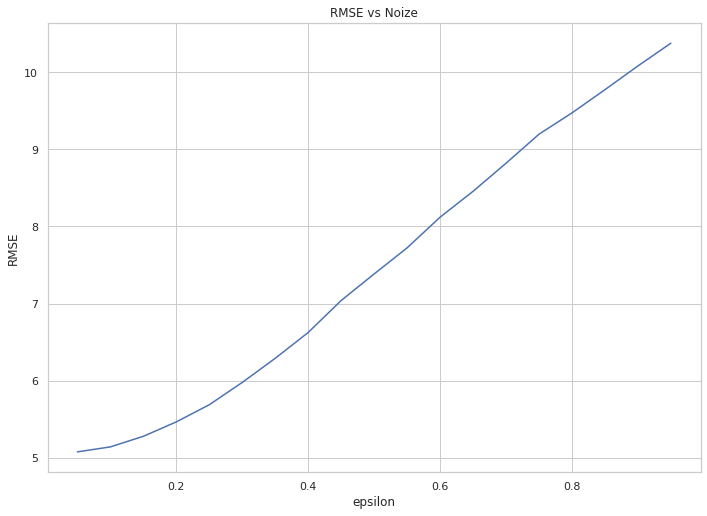

In [24]:
plt.figure(figsize=(11.7,8.27))
ax = plt.plot(eps_range, scores)
plt.title('RMSE vs Noize')
plt.xlabel('epsilon');
plt.ylabel('RMSE');
plt.savefig("rmse_noze.png")

In [25]:
df['eps0_01s'] = eps0_01s
df['eps0_03s'] = eps0_03s
df['eps0_05s'] = eps0_05s
df['eps0_10s'] = eps0_10s

In [26]:
er0_01 = mean_squared_error(df['eps0_01s'], df['target'], squared=False)
er0_03 = mean_squared_error(df['eps0_03s'], df['target'], squared=False)
er0_05 = mean_squared_error(df['eps0_05s'], df['target'], squared=False)
er0_10 = mean_squared_error(df['eps0_10s'], df['target'], squared=False)

In [27]:
mean_squared_error(df['predicted'], df['target'], squared=False)

5.051902

In [28]:
er0_01, er0_03, er0_05, er0_10

(9.188857, 15.9411, 20.064129, 24.248375)

In [29]:
feature_importances_score = (feature_importances.sum(axis=0))
feature_importances_score = feature_importances_score / np.linalg.norm(feature_importances_score, ord=1)

In [30]:
# prepare attributions for visualization
NAME_FEATURES = ['Temp t00', 'Temp t12', 'SWE', 'Precipitable Water', 'Reflectivity',
            'U-Wind', 'V-Wind', 'SWE Daily', 'NDSI', 'Daytime', 'Elevation', 'Soil Order']

x_axis_data = np.arange(len(NAME_FEATURES))
x_axis_data_labels = list(map(lambda idx: NAME_FEATURES[idx], x_axis_data))

width = 0.5

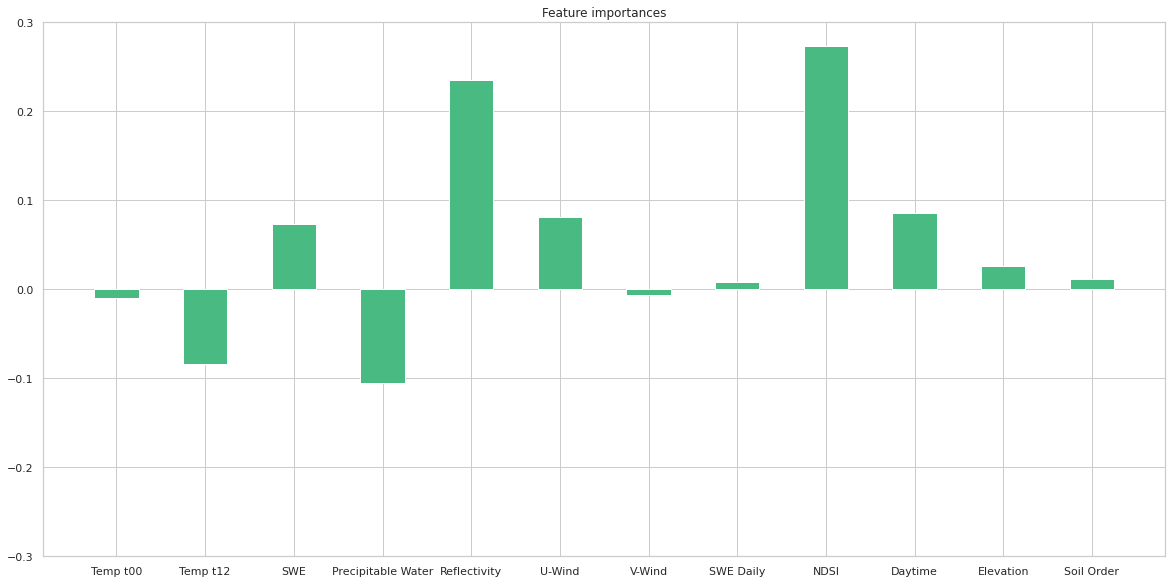

In [31]:
plt.figure(figsize=(8.27*2,8.27)) # (11.7,8.27)

ax = plt.subplot()
ax.set_title('Feature importances')

plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data + 1 * width, feature_importances_score, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)

ax.set(ylim=(-0.3, 0.30))

plt.savefig('feature_importances.png')
plt.show()

In [32]:
mask = df.predicted.values > 0
feature_importances_score = (feature_importances[mask].sum(axis=0))
feature_importances_score = feature_importances_score / np.linalg.norm(feature_importances_score, ord=1)

feature_importances[mask].mean(axis=0)

array([ 0.0254, -2.2217,  2.8557, -0.914 ,  4.7378,  1.6238, -0.1066,
        0.1874,  7.4037,  2.5955,  1.8481,  0.2011], dtype=float32)

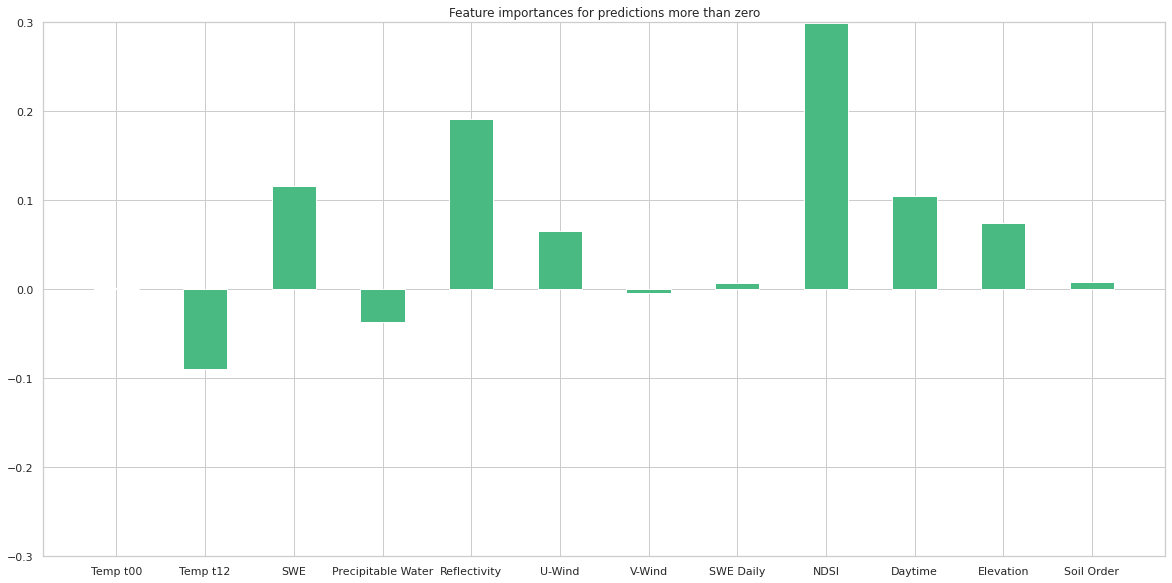

In [33]:
plt.figure(figsize=(8.27*2,8.27)) # (11.7,8.27)

ax = plt.subplot()
ax.set_title('Feature importances for predictions more than zero')

plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data + 1 * width, feature_importances_score, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)
ax.set(ylim=(-0.30, 0.30))

plt.savefig('feature_importances_swe_m0.png')
plt.show()

In [34]:
mask = df.predicted.values == 0
feature_importances_score = (feature_importances[mask].sum(axis=0))
feature_importances_score = feature_importances_score / np.linalg.norm(feature_importances_score, ord=1)

feature_importances[mask].mean(axis=0)

array([-0.4298,  0.4428, -1.9332, -2.6028,  1.2879,  0.4518, -0.0761,
        0.0083, -1.7037, -1.0019, -2.1003,  0.1179], dtype=float32)

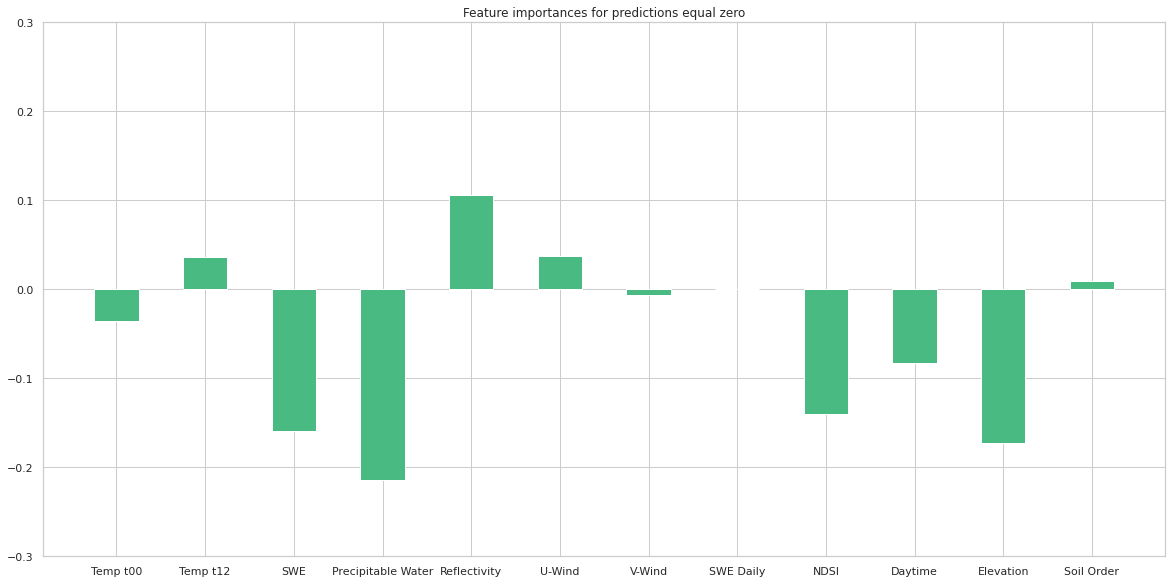

In [35]:
# prepare attributions for visualization
NAME_FEATURES = ['Temp t00', 'Temp t12', 'SWE', 'Precipitable Water', 'Reflectivity',
            'U-Wind', 'V-Wind', 'SWE Daily', 'NDSI', 'Daytime', 'Elevation', 'Soil Order']

x_axis_data = np.arange(len(NAME_FEATURES))
x_axis_data_labels = list(map(lambda idx: NAME_FEATURES[idx], x_axis_data))

width = 0.5

plt.figure(figsize=(8.27*2,8.27)) # (11.7,8.27)

ax = plt.subplot()
ax.set_title('Feature importances for predictions equal zero')

plt.rc('font', size=FONT_SIZE)            # fontsize of the text sizes
plt.rc('axes', titlesize=FONT_SIZE)       # fontsize of the axes title
plt.rc('axes', labelsize=FONT_SIZE)       # fontsize of the x and y labels
plt.rc('legend', fontsize=FONT_SIZE - 4)  # fontsize of the legend

ax.bar(x_axis_data + 1 * width, feature_importances_score, width, align='center', alpha=1.0, color='#49ba81')
ax.autoscale_view()
plt.tight_layout()

ax.set_xticks(x_axis_data + 0.5)
ax.set_xticklabels(x_axis_data_labels)
ax.set(ylim=(-0.30, 0.30))

plt.savefig('feature_importances_eq0.png')
plt.show()

In [36]:
errors = np.abs(
    df.loc[df.time > "2020-01-01"].target.values - df.loc[df.time > "2020-01-01"].predicted.values)
print("Error: for season 2020/2021", ((errors**2).mean())**0.5)

errors = np.abs(
    df.loc[df.time < "2020-01-01"].target.values - df.loc[df.time < "2020-01-01"].predicted.values)
print("Error before season 2020: ", ((errors**2).mean())**0.5)

errors = np.abs(
    df.target.values - df.predicted.values)
print("Error: ", ((errors**2).mean())**0.5)

Error: for season 2020/2021 3.5071122250011393
Error before season 2020:  5.77495896626216
Error:  5.0519019444993125


In [37]:
df.head()

,target,predicted,time,fold,eps0_01s,eps0_03s,eps0_05s,eps0_10s
cell_id,,,,,,,,
0003f387-71c4-48f6-b2b0-d853bd4f0aba,22.500000,20.664637,2018-04-26,2,13.498299,4.794923,0.077353,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,0.000000,0.000000,2019-03-16,2,0.000000,0.000000,0.000000,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,53.599998,51.773689,2019-04-18,2,39.021809,17.773314,2.187906,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,52.299999,51.549381,2019-04-28,2,38.983269,20.305958,9.719672,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,48.099998,45.795982,2019-06-08,2,37.199314,23.602613,13.433374,0.0


In [38]:
sierras_cells = cells[cells.region == 'sierras'].cell_id.values
rockies_cells = cells[cells.region == 'central rockies'].cell_id.values
other_cells = cells[cells.region == 'other'].cell_id.values

In [131]:
df.head()

,target,predicted,time,fold,eps0_01s,eps0_03s,eps0_05s,eps0_10s
cell_id,,,,,,,,
0003f387-71c4-48f6-b2b0-d853bd4f0aba,22.500000,20.664637,2018-04-26,2,13.498299,4.794923,0.077353,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,0.000000,0.000000,2019-03-16,2,0.000000,0.000000,0.000000,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,53.599998,51.773689,2019-04-18,2,39.021809,17.773314,2.187906,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,52.299999,51.549381,2019-04-28,2,38.983269,20.305958,9.719672,0.0
0003f387-71c4-48f6-b2b0-d853bd4f0aba,48.099998,45.795982,2019-06-08,2,37.199314,23.602613,13.433374,0.0


In [137]:
for y in range(2014, 2022):
    subset = df[df.time.dt.year == y]
    score = mean_squared_error(subset.target, subset.predicted, squared=False)
    print(f"Score {y} y. \t {score:.3f}")

Score 2014 y. 	 2.496
Score 2015 y. 	 3.619
Score 2016 y. 	 5.234
Score 2017 y. 	 8.191
Score 2018 y. 	 4.394
Score 2019 y. 	 6.511
Score 2020 y. 	 3.698
Score 2021 y. 	 3.319


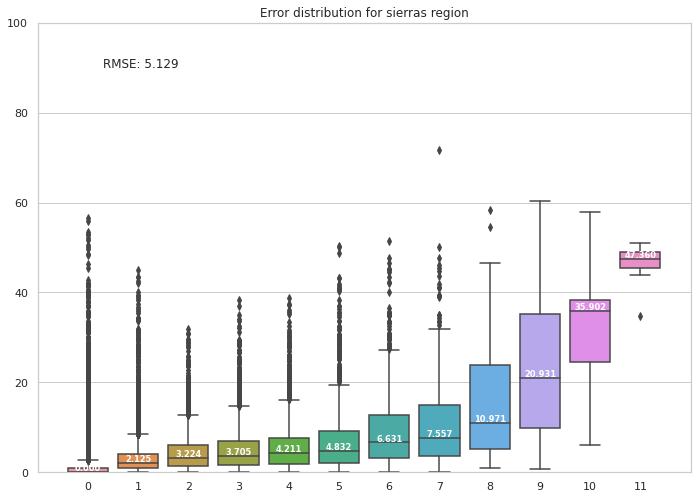

In [39]:
ax = get_figure(
    df[df.index.isin(sierras_cells)].target.values, df[df.index.isin(sierras_cells)].predicted.values)
plt.title(f"Error distribution for sierras region")
plt.savefig('sierras.png')
plt.show()

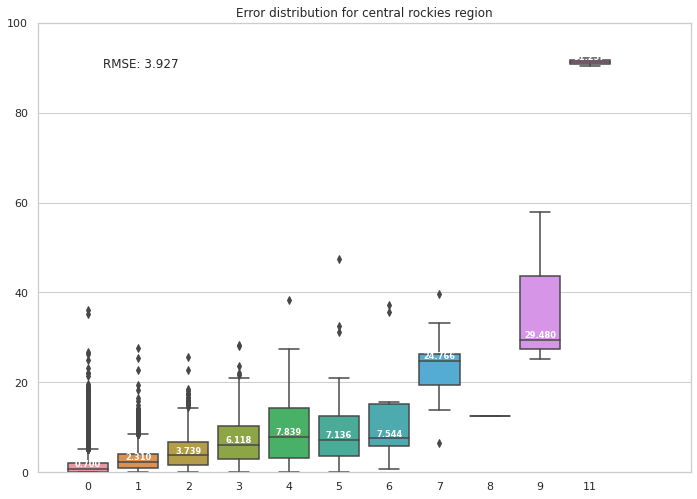

In [40]:
ax = get_figure(
    df[df.index.isin(rockies_cells)].target.values, df[df.index.isin(rockies_cells)].predicted.values)
plt.title(f"Error distribution for central rockies region")
plt.savefig('central_rockies.png')
plt.show()

In [139]:
cells.region.unique()

array(['sierras', 'central rockies', 'other'], dtype=object)

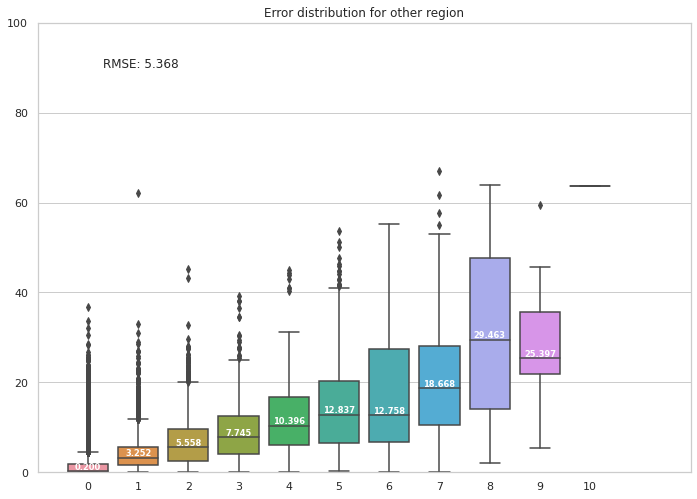

In [41]:
ax = get_figure(
    df[df.index.isin(other_cells)].target.values, df[df.index.isin(other_cells)].predicted.values)
plt.title(f"Error distribution for other region")
plt.savefig('other_region.png')
plt.show()

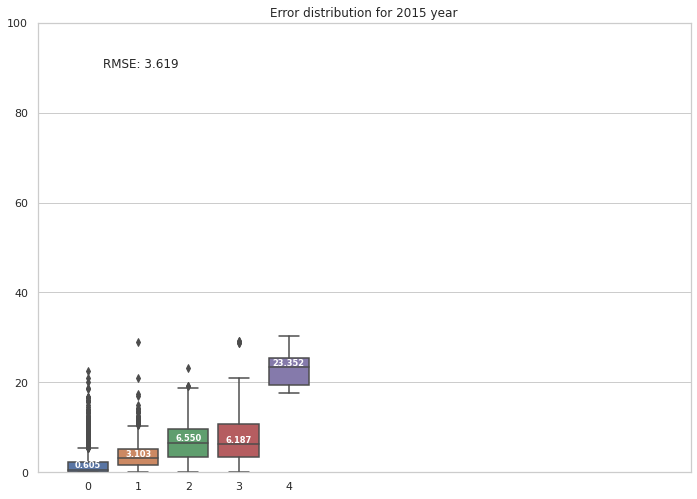

In [42]:
year = 2015
subset = df[df.time.dt.year == year]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for {year} year")
plt.savefig(f'{year}.png')
plt.show()

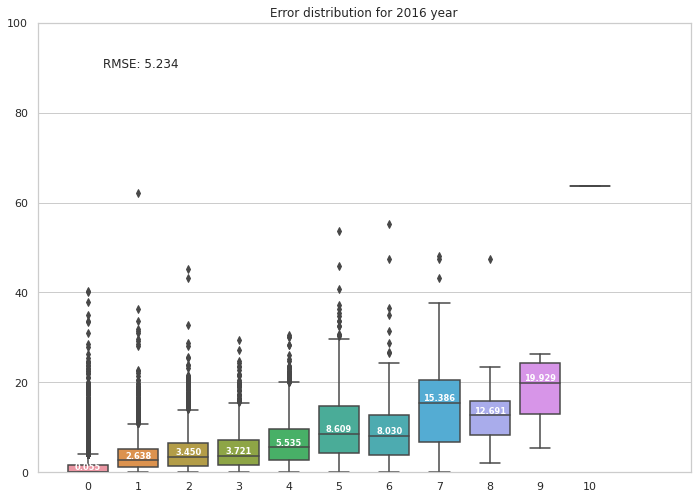

In [43]:
year = 2016
subset = df[df.time.dt.year == year]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for {year} year")
plt.savefig(f'{year}.png')
plt.show()

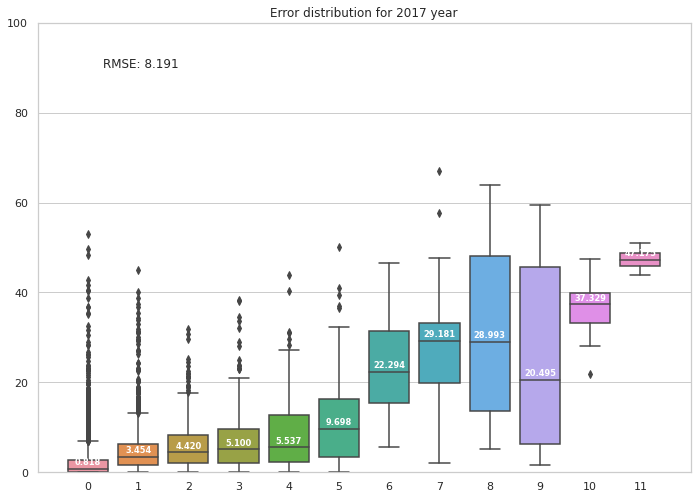

In [44]:
year = 2017
subset = df[df.time.dt.year == year]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for {year} year")
plt.savefig(f'{year}.png')
plt.show()

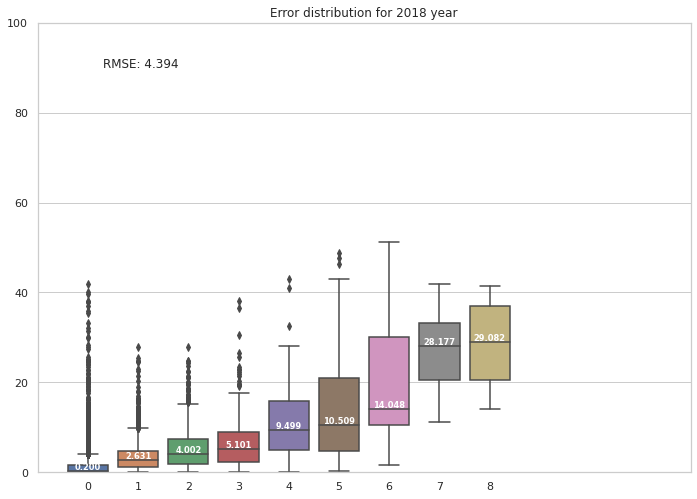

In [45]:
year = 2018
subset = df[df.time.dt.year == year]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for {year} year")
plt.savefig(f'{year}.png')
plt.show()

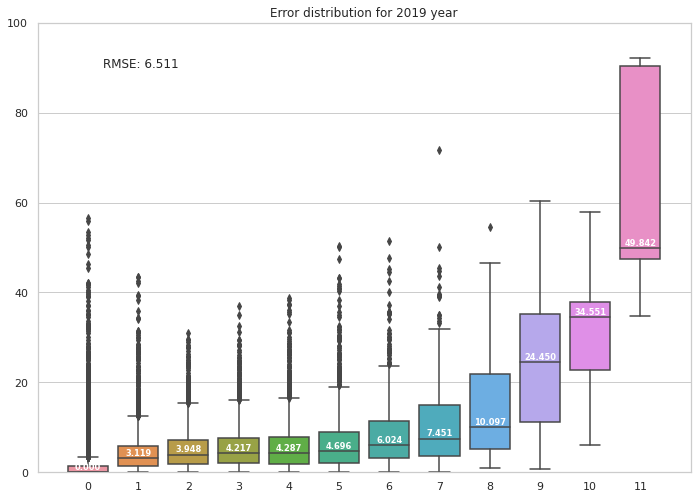

In [46]:
year = 2019
subset = df[df.time.dt.year == year]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for {year} year")
plt.savefig(f'{year}.png')
plt.show()

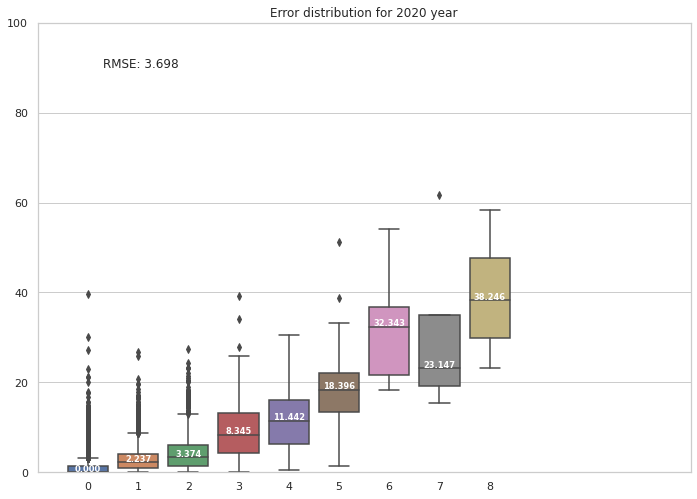

In [47]:
year = 2020
subset = df[df.time.dt.year == year]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for {year} year")
plt.savefig(f'{year}.png')
plt.show()

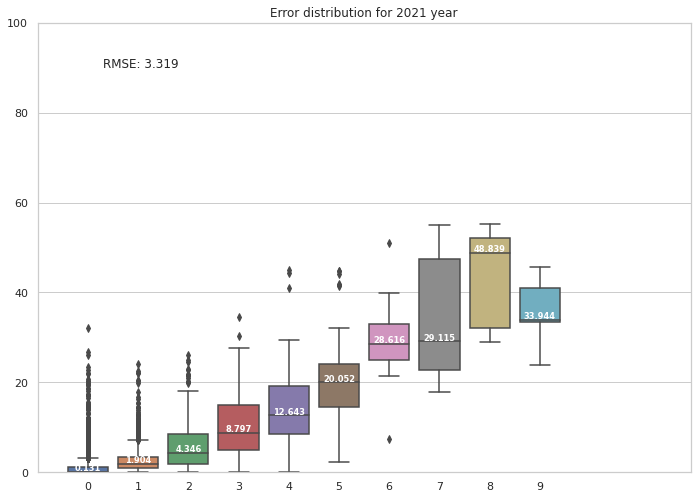

In [48]:
year = 2021
subset = df[df.time.dt.year == year]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for {year} year")
plt.savefig(f'{year}.png')
plt.show()

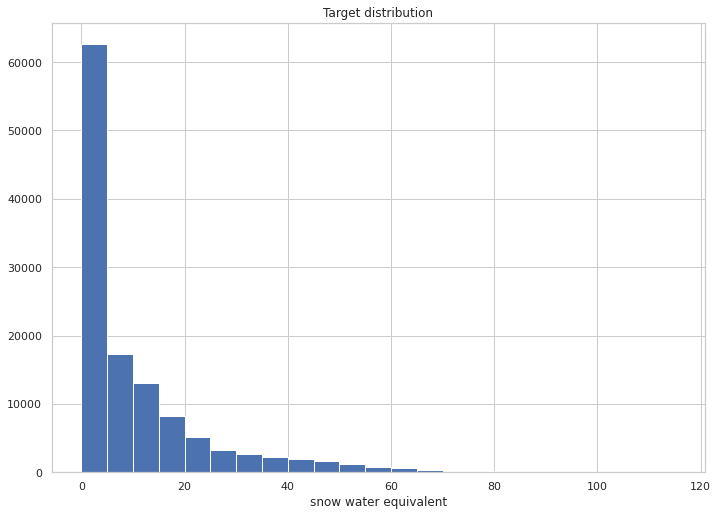

In [49]:
ax = df.target.hist(
    bins=np.arange(0,120,5), figsize=(11.7,8.27))
ax.set_title('Target distribution');
ax.set_xlabel('snow water equivalent')
plt.savefig('target_hist.png')

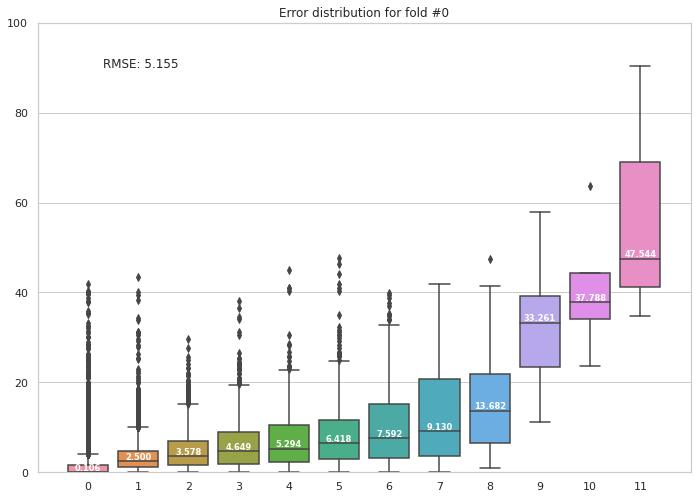

In [50]:
fold_idx = 0
subset = df[df.fold == fold_idx]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for fold #{fold_idx}")
plt.savefig(f'fold_{fold_idx}.png')
plt.show()

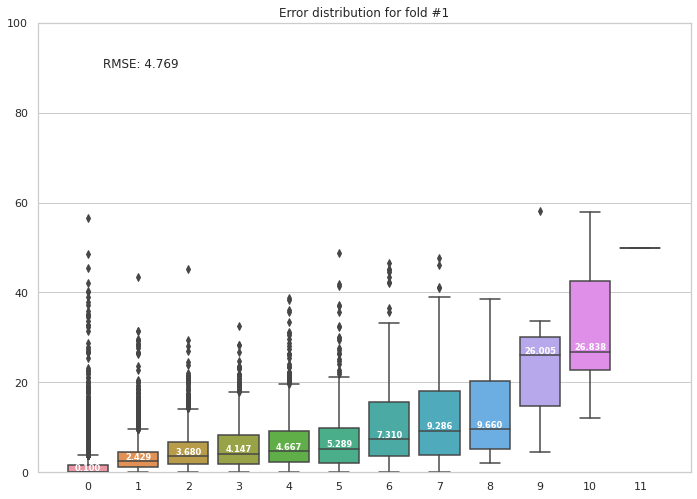

In [51]:
fold_idx = 1
subset = df[df.fold == fold_idx]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for fold #{fold_idx}")
plt.savefig(f'fold_{fold_idx}.png')
plt.show()

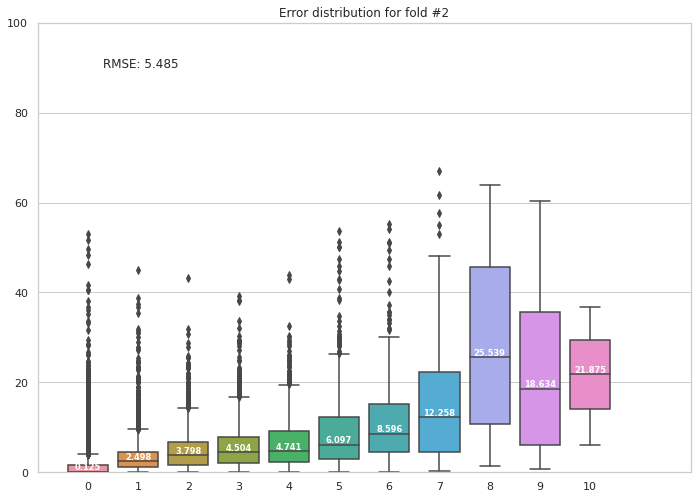

In [52]:
fold_idx = 2
subset = df[df.fold == fold_idx]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for fold #{fold_idx}")
plt.savefig(f'fold_{fold_idx}.png')
plt.show()

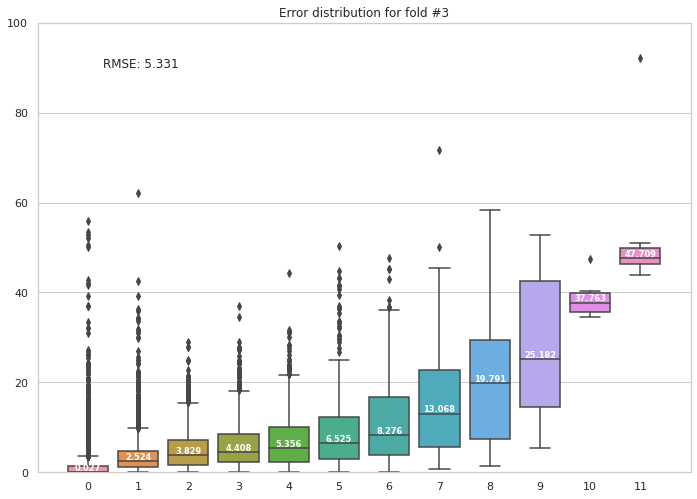

In [53]:
fold_idx = 3
subset = df[df.fold == fold_idx]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for fold #{fold_idx}")
plt.savefig(f'fold_{fold_idx}.png')
plt.show()

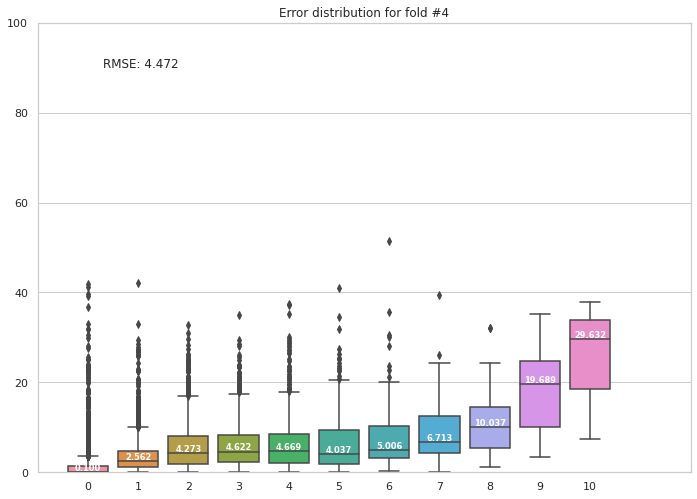

In [54]:
fold_idx = 4
subset = df[df.fold == fold_idx]
ax = get_figure(subset.target.values, subset.predicted.values)
plt.title(f"Error distribution for fold #{fold_idx}")
plt.savefig(f'fold_{fold_idx}.png')
plt.show()

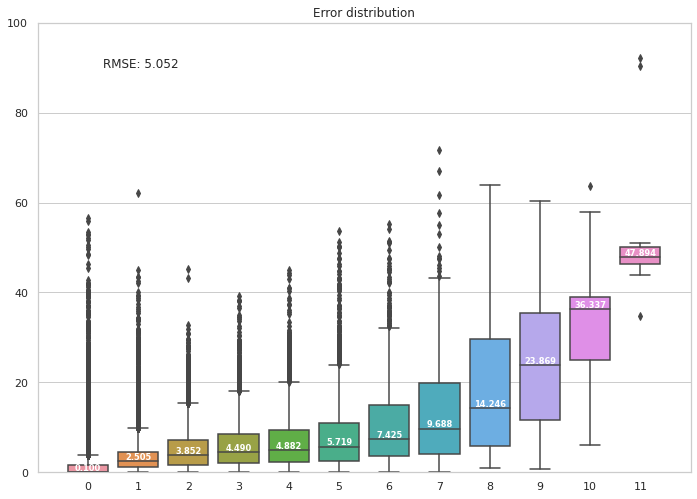

In [55]:
ax = get_figure(df.target.values, df.predicted.values)
plt.title(f"Error distribution")
plt.savefig('Error_distribution.png')
plt.show()

In [56]:
df.to_csv("scores.csv")

In [57]:
mp = gpd.read_file("tl_2017_us_state.shp")

In [58]:
west = mp[mp['STUSPS'].isin([
    'WA', 'OR', 'ID', 'MT', 'WY', 'CO', 'UT', 'NV', 'CA', 'NM', 'AZ'])]

In [59]:
cell_id = df.reset_index().groupby('cell_id').fold.first().index
fold_idx = df.reset_index().groupby('cell_id').fold.first().to_numpy()

In [60]:
cells = cells.set_index(cell_id)
cells.loc[cell_id, 'fold'] = fold_idx

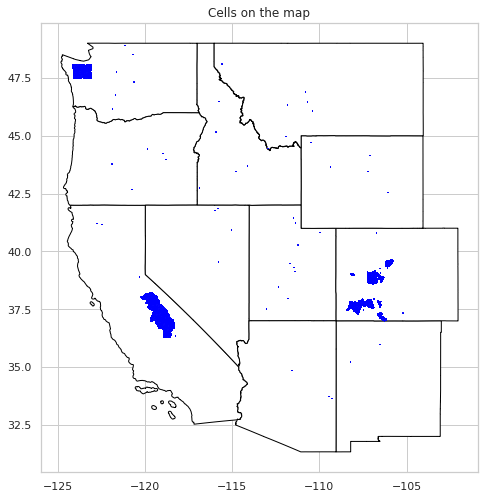

In [61]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
west.plot(ax=ax, color='white', edgecolor='black')
cells.plot(ax=ax, color='white', edgecolor='blue')
plt.title("Cells on the map")
plt.savefig("cells.png")
plt.show();

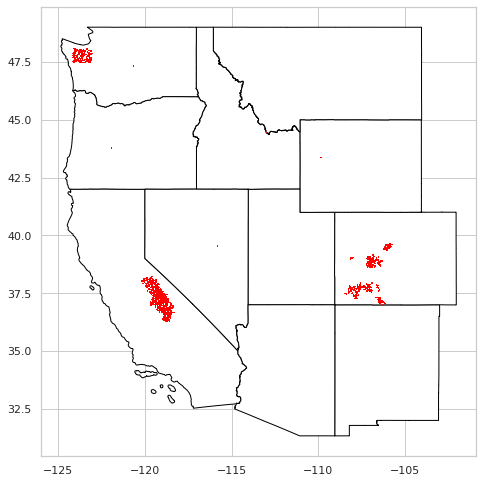

In [62]:
fig, ax = plt.subplots()

ax.set_aspect('equal')
west.plot(ax=ax, color='white', edgecolor='black')

cells[cells.fold == 1].plot(ax=ax, color='white', edgecolor='red')

plt.show();

In [92]:
band_values.shape

(10, 2526, 18130)

In [94]:
band_values.mean(axis=(-1,-2)), band_values.std(axis=(-1,-2))

(array([ 0.5159, -0.0494,  0.0275, -0.0423, -0.6839,  0.0411,  0.0013,
         0.0136,  0.1289,  0.0556], dtype=float32),
 array([0.6316, 0.4852, 1.5611, 0.7637, 0.8991, 0.2446, 0.2121, 0.1594,
        0.3304, 0.5873], dtype=float32))

In [95]:
band_values.min(axis=(-1,-2)), band_values.max(axis=(-1,-2))

(array([-1.7123, -2.5978, -1.    , -1.1305, -1.    , -2.6066, -1.5417,
         0.    , -0.6029, -1.1319], dtype=float32),
 array([ 2.7096,  1.7807,  6.7194,  5.7319,  6.15  ,  2.1511,  1.5387,
        11.049 ,  0.9859,  1.2595], dtype=float32))

In [87]:
# ds.NDSI.loc(
#     xr.DataArray(data_idx, coords='time'),
#     xr.DataArray(cell_idx, coords='cell_id')
# )


In [89]:
# ndsi = ds.NDSI.sel(
#     time=xr.DataArray(data_idx, coords='cells'),
#     cell_id=xr.DataArray(cell_idx, coords='cells')
# )